# Convolutional variational autoencoder (CVAE)

In [1]:
import matplotlib.pyplot
import numpy
import sklearn.model_selection
import tensorflow
import tensorflow_probability

In [2]:
BASE_DEPTH = 32
CONVOLUTION_OPTIONS = {"activation": tensorflow.nn.leaky_relu, "kernel_size": 5, "padding": "same"}
ENCODED_SIZE = 64
EPOCHS = 100000
INPUT_SHAPE = (28, 28, 1)
OPTIMIZER = tensorflow.keras.optimizers.Adam(0.0001)
PRIOR = tensorflow_probability.distributions.Independent(tensorflow_probability.distributions.Normal(tensorflow.zeros(ENCODED_SIZE), 1), 1)

In [3]:
def preprocess(image):
    image = tensorflow.image.resize(image, (28, 28))
    
    return tensorflow.image.rgb_to_grayscale(image)

def render_images(images):
    matplotlib.pyplot.figure(figsize=(12, 12))

    for index, image in enumerate(images[:25]):
        axis = matplotlib.pyplot.subplot(5, 5, index + 1)

        matplotlib.pyplot.imshow(image[:, :, 0])

        matplotlib.pyplot.axis("off")

In [4]:
%time x_0 = numpy.load("../../data/objects/0.npy")

training_0, test_0 = sklearn.model_selection.train_test_split(x_0)

CPU times: user 4.05 ms, sys: 181 ms, total: 185 ms
Wall time: 183 ms


<Figure size 864x864 with 0 Axes>

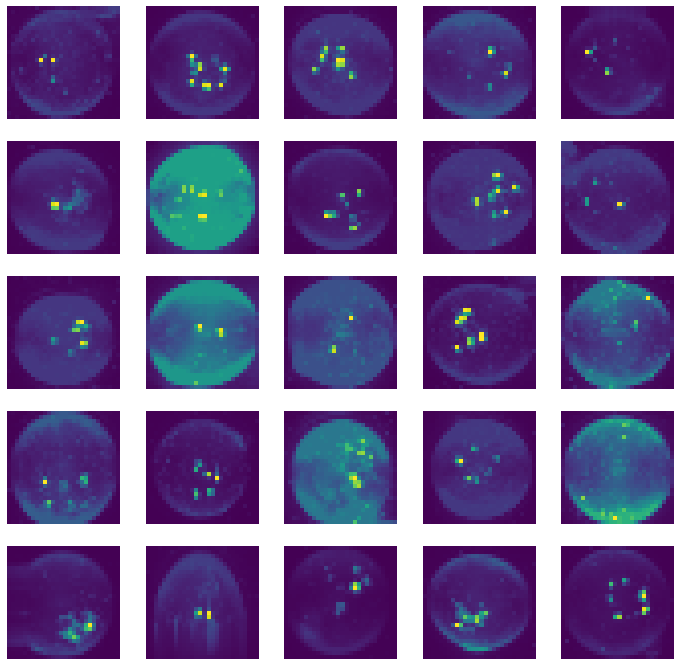

In [5]:
# Training, 0 (Membrane)

training_0 = tensorflow.data.Dataset.from_tensor_slices(training_0)

training_0 = training_0.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

training_0 = training_0.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

matplotlib.pyplot.figure(figsize=(12, 12))

render_images([image.numpy() for image in training_0.take(1)][0][:25])

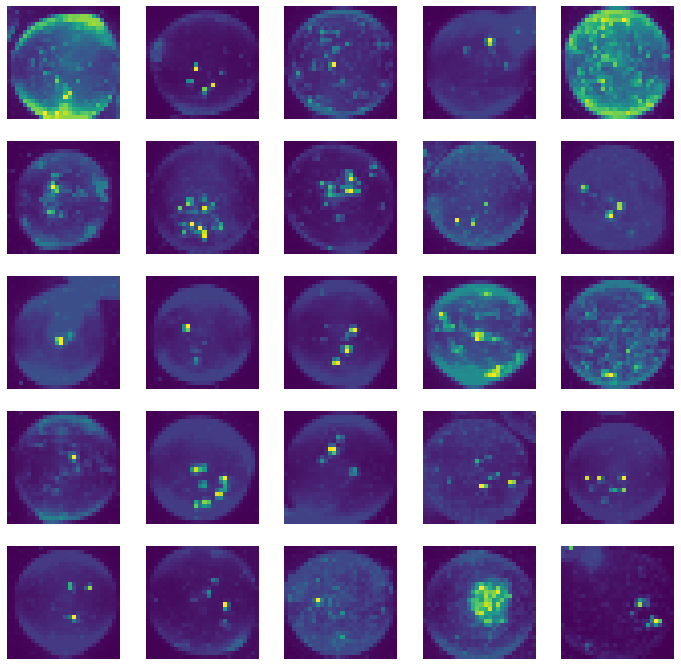

In [6]:
# Test, 0 (Membrane)

test_0 = tensorflow.data.Dataset.from_tensor_slices(test_0)

test_0 = test_0.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

test_0 = test_0.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

render_images([image.numpy() for image in test_0.take(1)][0][:25])

In [7]:
%time x_1 = numpy.load("../../data/objects/1.npy")

training_1, test_1 = sklearn.model_selection.train_test_split(x_1)

CPU times: user 140 µs, sys: 3.93 s, total: 3.93 s
Wall time: 3.93 s


<Figure size 864x864 with 0 Axes>

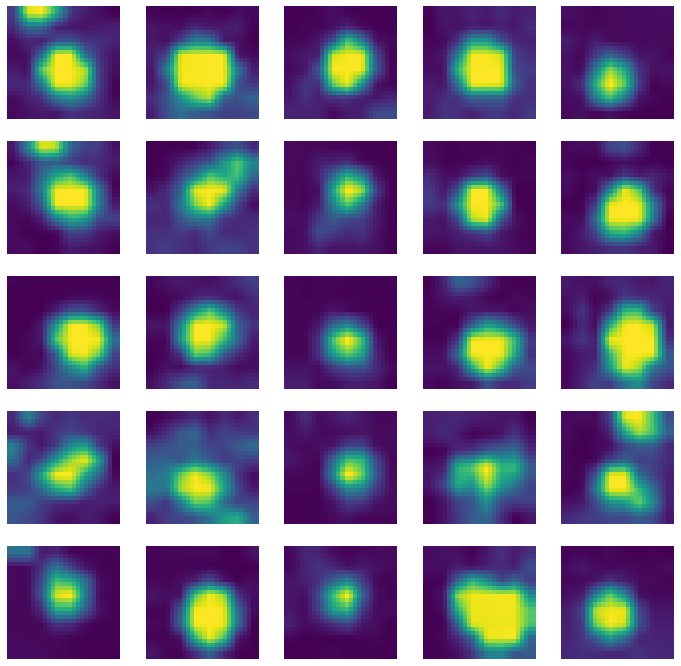

In [8]:
# Training, 1 (Foci)

training_1 = tensorflow.data.Dataset.from_tensor_slices(training_1)

training_1 = training_1.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

training_1 = training_1.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

matplotlib.pyplot.figure(figsize=(12, 12))

render_images([image.numpy() for image in training_1.take(1)][0][:25])

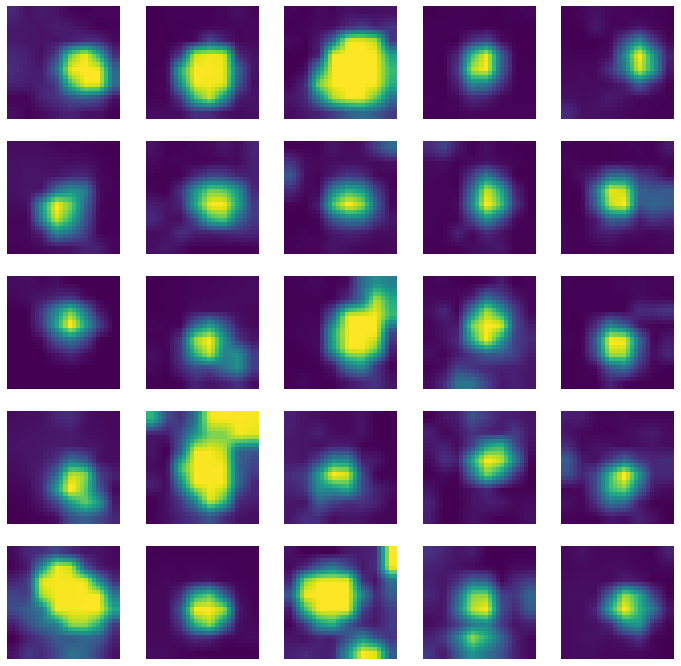

In [9]:
# Test, 1 (Foci)

test_1 = tensorflow.data.Dataset.from_tensor_slices(test_1)

test_1 = test_1.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

test_1 = test_1.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

render_images([image.numpy() for image in test_1.take(1)][0][:25])

In [11]:
decoder = tensorflow.keras.Sequential([
    tensorflow.keras.layers.InputLayer(input_shape=(ENCODED_SIZE,)),
    tensorflow.keras.layers.Reshape([1, 1, ENCODED_SIZE]),
    tensorflow.keras.layers.Conv2DTranspose(2 * BASE_DEPTH, 7, strides=1, padding="valid", activation=tensorflow.nn.leaky_relu),
    tensorflow.keras.layers.Conv2DTranspose(2 * BASE_DEPTH, strides=1, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2DTranspose(2 * BASE_DEPTH, strides=2, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2DTranspose(1 * BASE_DEPTH, strides=1, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2DTranspose(1 * BASE_DEPTH, strides=2, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2DTranspose(1 * BASE_DEPTH, strides=1, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2D(1, 5, strides=1, padding="same", activation=None),
    tensorflow.keras.layers.Flatten(),
    tensorflow_probability.layers.IndependentBernoulli(INPUT_SHAPE, tensorflow_probability.distributions.Bernoulli.logits),
])

activity_regularizer = tensorflow_probability.layers.KLDivergenceRegularizer(PRIOR, weight=1.0)
        
units = tensorflow_probability.layers.MultivariateNormalTriL.params_size(ENCODED_SIZE)
        
encoder = tensorflow.keras.Sequential([
    tensorflow.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tensorflow.keras.layers.Lambda(lambda x: tensorflow.cast(x, tensorflow.float32) - 0.5),
    tensorflow.keras.layers.Conv2D(1 * BASE_DEPTH, strides=1, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2D(1 * BASE_DEPTH, strides=2, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2D(2 * BASE_DEPTH, strides=1, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2D(2 * BASE_DEPTH, strides=2, **CONVOLUTION_OPTIONS),
    tensorflow.keras.layers.Conv2D(4 * ENCODED_SIZE, 7, strides=1, padding="valid", activation=tensorflow.nn.leaky_relu),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(units=units, activation=None),    
    tensorflow_probability.layers.MultivariateNormalTriL(ENCODED_SIZE, activity_regularizer=activity_regularizer),
])

model = tensorflow.keras.Model(encoder.inputs, decoder(encoder.outputs[0]))

model.compile(OPTIMIZER, lambda x, y: 0.0 - y.log_prob(x))

In [14]:
model.fit(
    callbacks=[
        tensorflow.keras.callbacks.TensorBoard(
            histogram_freq=1, 
            log_dir="./logs", 
            write_images=True,
        )
    ],
    epochs=EPOCHS,
    validation_data=test_1,
    x=training_1,
)

KeyboardInterrupt: 

In [ ]:
x = next(iter(training_1))

x_hat = model(x)

assert isinstance(x_hat, tensorflow_probability.distributions.Distribution)

render_images(x[:25])

In [ ]:
render_images(x_hat.sample()[:25])

In [ ]:
render_images(x_hat.mode()[:25])

In [ ]:
render_images(x_hat.mean()[:25])

In [ ]:
z = PRIOR.sample(25)

x_tilde = decoder(z)

assert isinstance(x_tilde, tensorflow_probability.distributions.Distribution)

In [ ]:
render_images(x_tilde.sample()[:25])

In [ ]:
render_images(x_tilde.mode()[:25])

In [ ]:
render_images(x_tilde.mean()[:25])